# Predicting if a sample is tumor or normal from miRNA expression data using bagging support vector machines

### Import modules and the data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)
plt.xkcd()

In [2]:
data = pd.read_table("cervical.txt")

### Take a look at the top of the data, we have 714 features and 58 samples, plus a column of miRNA names.

In [3]:
print(data.shape)
data.head()

(714, 59)


,ID,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,let-7a,865,810,5505,6692,1456,588,9,4513,1962,...,37,3174,116,1722,68,12121,14398,39196,198,1422
1,let-7a*,3,12,30,73,6,2,0,199,10,...,0,648,4,212,6,2,80,164,18,1
2,let-7b,975,2790,4912,24286,1759,508,33,6162,1455,...,99,102358,184,28274,401,14471,24097,73139,669,2492
3,let-7b*,15,18,27,119,11,3,0,116,17,...,0,334,1,189,5,34,115,230,4,15
4,let-7c,828,1251,2973,6413,713,339,23,2002,476,...,34,1711,22,3127,199,3186,1454,5883,167,321


### Let's look at the library sizes (total read counts per sample)

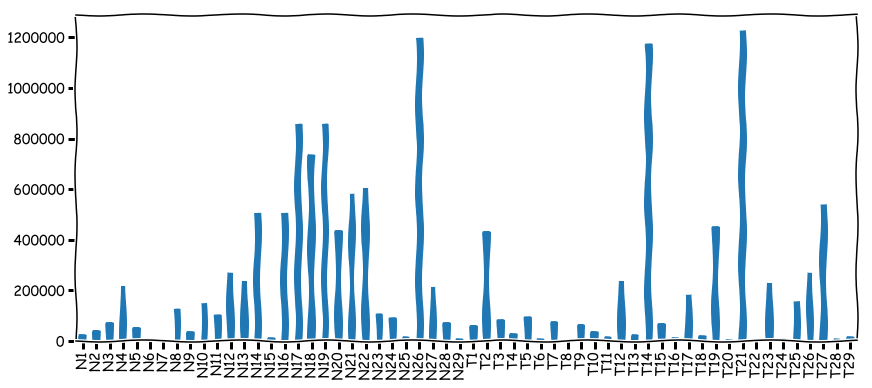

In [11]:
sizes = data.sum(numeric_only=True)
sizes.plot.bar()

### Normalization

Our library sizes are very different.  Standard practice is to use some normalization method.

Here I use the normalization method of counts per milion (CPM).  We divide each count by the library size to give the proportion of total reads for each gene, then multiply by 1 million to get counts per 1 million.

In [12]:
ID = data.ID
data = data.drop('ID', 1)
sums = data.sum()
cpm = (data.div(sums))*1000000
cpm.insert(loc=0, column='ID', value=ID)

In [13]:
print(cpm.shape)
cpm.head()

(714, 59)


,ID,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,let-7a,38531.783153,20352.781547,76760.042947,30209.461900,27533.518655,64283.371597,6807.866868,36119.603669,52587.847436,...,11923.944570,2586.676903,33001.422475,7373.595506,8835.758836,76912.338589,52987.005340,72541.794445,29320.302088,87036.356959
1,let-7a*,133.636242,301.522690,418.310861,329.541351,113.462302,218.650924,0.000000,1592.688041,268.031842,...,0.000000,528.092827,1137.980085,907.782954,779.625780,12.690758,294.413143,303.522152,2665.482008,61.207002
2,let-7b,43431.778698,70104.025328,68491.431599,109633.441676,33263.364914,55537.334645,24962.178517,49317.305076,38998.633038,...,31904.608443,83417.477754,52347.083926,121069.128528,52104.989605,91823.979187,88680.918716,135361.626286,99067.081297,152527.849186
3,let-7b*,668.181211,452.284034,376.479775,537.197544,208.014221,327.976386,0.000000,928.401069,455.654132,...,0.000000,272.195994,284.495021,809.297068,649.688150,215.742885,423.218892,425.671311,592.329335,918.105031
4,let-7c,36883.602833,31433.740389,41454.606300,28949.981943,13483.103572,37061.331584,17397.881997,16022.921902,12758.315688,...,10957.138253,1394.393251,6258.890469,13389.798575,25857.588358,20216.377423,5350.958867,10887.931848,24729.749741,19647.447668


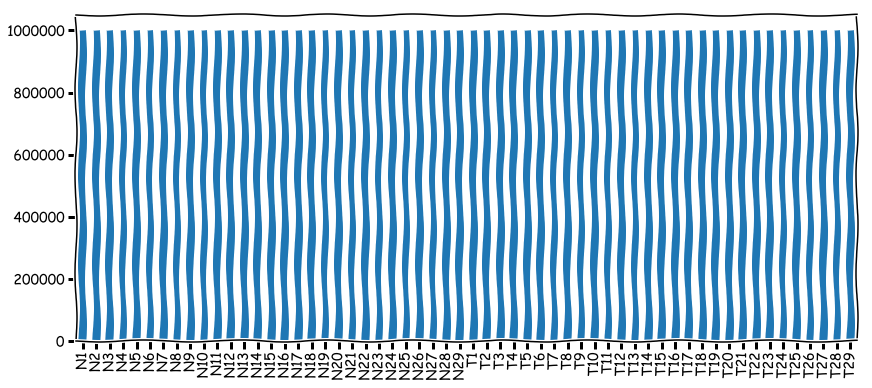

In [14]:
sizes = cpm.sum(numeric_only=True)
sizes.plot.bar()

### Here I re-format the data into a form suitable for input into the machine learning algorithm (put smples as rows and features as columns and create a vector of class labels for scikit-learn)

In [7]:
cpm = cpm.transpose()
cpm = np.array(cpm[1:])
class_labels = np.array(["normal"]*29 + ["tumor"]*29)

In [8]:
cpm

array([[38531.78315292441, 133.63624214887076, 43431.778698383, ..., 0.0,
        0.0, 44.54541404962359],
       [20352.7815468114, 301.5226895823911, 70104.02532790593, ...,
        25.12689079853259, 50.25378159706518, 0.0],
       [76760.0429465817, 418.3108607443144, 68491.43159920242, ..., 0.0,
        0.0, 27.88739071628763],
       ..., 
       [72541.79444517446, 303.5221524902697, 135361.626286499, ...,
        7.402979329030968, 12.955213825804195, 12.955213825804195],
       [29320.302087960907, 2665.482007996446, 99067.08129720124, ..., 0.0,
        0.0, 0.0],
       [87036.35695923613, 61.20700208103807, 152527.84918594686, ..., 0.0,
        0.0, 0.0]], dtype=object)

In [9]:
class_labels

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor'],
      dtype='<U6')

### Now we need to scale the data, that prevents the really highly expressed miRNA's from overwhelming influence on the model.  We get a warning about converting data type but thats okay.

In [10]:
from sklearn.preprocessing import StandardScaler

sc_cpm = StandardScaler()
cpm = sc_cpm.fit_transform(cpm)

C:\Users\tom\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
cpm

array([[ 0.16375984, -0.71724117, -0.8802064 , ..., -0.28985132,
        -0.48013976,  0.7757562 ],
       [-0.53465168, -0.48861301, -0.09556051, ...,  0.81048475,
         4.80271218, -0.25745491],
       [ 1.63243551, -0.3295706 , -0.1429999 , ..., -0.28985132,
        -0.48013976,  0.38938074],
       ..., 
       [ 1.47037637, -0.48589014,  1.82419185, ...,  0.03433384,
         0.88175728,  0.04303552],
       [-0.19013223,  2.73063234,  0.75647656, ..., -0.28985132,
        -0.48013976, -0.25745491],
       [ 2.02723696, -0.81587548,  2.32918892, ..., -0.28985132,
        -0.48013976, -0.25745491]])

### Train/Test Split - split the data into a training set and a testing set.  Lets use 80% of the data to train and 20% to test.

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cpm, class_labels, test_size = 0.2)

In [74]:
print(X_train.shape)
print(X_test.shape)

(46, 714)
(12, 714)


### Now we'll use support vector machines with a linear kernel to create a classifier.  Here I use bagging (bootstrap aggregating), an ensemble method, to avoid overfitting a small data set. 

In [75]:
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1)
classifier = BaggingClassifier(base_estimator = svc, n_estimators = 10)
classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

### Predict classifications of the test set data with our model

In [76]:
predictions = classifier.predict(X_test)
print(predictions)

['tumor' 'normal' 'normal' 'normal' 'tumor' 'tumor' 'normal' 'normal'
 'normal' 'tumor' 'tumor' 'tumor']


### Here is the ground truth:

In [77]:
print(y_test)

['tumor' 'normal' 'normal' 'normal' 'normal' 'tumor' 'normal' 'normal'
 'normal' 'tumor' 'normal' 'tumor']


### Now lets make a confusion matrix to show how well our model works

In [78]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
print(cm)

[[6 2]
 [0 4]]


### Let's use k-fold cross validation to measure performance (bias and variance)

In [79]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("The mean accuracy is: ", accuracies.mean())
print("The standard deviation is: ", accuracies.std())

The mean accuracy is:  0.95
The standard deviation is:  0.1
